# Uncovering Plant Traits -- For Fun : )

This final version of my notebook documents the final results of my efforts to train a multi-input and multi-output deep learning model to predict 6 core plant traits. Specifically, this model ingests both plant image data and ancillary tabular features.

Table of contents:
- Data pipeline for pre-processing images and tabular data => feature extraction and data cleaning
- Constructing Data Augmentation Pipeline with Keras_cv
- Creating the model using EfficientNetV2Backbone
- Defining custom loss function, metrics, and learning rate schedueler
- Training the model

### 📚 | Import Libraries

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "jax" # you can also use tensorflow or torch

import keras_cv
import keras
from keras import ops
import tensorflow as tf

import cv2
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import joblib

import matplotlib.pyplot as plt

2024-03-22 01:07:07.045284: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-22 01:07:07.045347: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-22 01:07:07.046973: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### ⚙️ | Configuration
Setting up a `config` object will allow us to avoid errors fro typos or minor mistakes.

In [ ]:
class CFG:
    verbose = 1
    seed = 42
    preset = "efficientnetv2_b2_imagenet"
    image_size = [224, 224]
    epochs = 10
    batch_size = 96
    lr_mode = "step"
    drop_remainder = True
    num_classes = 6
    num_folds = 5
    fold = 0
    class_names = ['X4_mean', 'X11_mean', 'X18_mean',
                   'X26_mean', 'X50_mean', 'X3112_mean',]
    aux_class_names = list(map(lambda x: x.replace("mean","sd"), class_names))
    num_classes = len(class_names)
    aux_num_classes = len(aux_class_names)

#### 📖 | Data
Let's load in our data. To make data pipeline processes more efficient, we'll append the `path` of our images to their respective row in the data tables.

In [ ]:
# Train + Valid
df = pd.read_csv(f'{BASE_PATH}/train.csv')
df['image_path'] = f'{BASE_PATH}/train_images/'+df['id'].astype(str)+'.jpeg'
df.loc[:, CFG.aux_class_names] = df.loc[:, CFG.aux_class_names].fillna(-1)
display(df.head(2))

# Test
test_df = pd.read_csv(f'{BASE_PATH}/test.csv')
test_df['image_path'] = f'{BASE_PATH}/test_images/'+test_df['id'].astype(str)+'.jpeg'
FEATURE_COLS = test_df.columns[1:-1].tolist()
display(test_df.head(2))

,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,X26_mean,X50_mean,X3112_mean,X4_sd,X11_sd,X18_sd,X26_sd,X50_sd,X3112_sd,image_path
0,192027691,12.235703,374.466675,62.524445,72.256844,773.592041,33.277779,125,149,136,...,1.243779,1.849375,50.216034,0.008921,1.601473,0.025441,0.153608,0.279610,15.045054,/kaggle/input/planttraits2024/train_images/192...
1,195542235,17.270555,90.239998,10.351111,38.220940,859.193298,40.009777,124,144,138,...,0.642940,1.353468,574.098472,0.003102,0.258078,0.000866,0.034630,0.010165,11.004477,/kaggle/input/planttraits2024/train_images/195...


,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,VOD_X_1997_2018_multiyear_mean_m04,VOD_X_1997_2018_multiyear_mean_m05,VOD_X_1997_2018_multiyear_mean_m06,VOD_X_1997_2018_multiyear_mean_m07,VOD_X_1997_2018_multiyear_mean_m08,VOD_X_1997_2018_multiyear_mean_m09,VOD_X_1997_2018_multiyear_mean_m10,VOD_X_1997_2018_multiyear_mean_m11,VOD_X_1997_2018_multiyear_mean_m12,image_path
0,195066138,10.55810,961.500000,31.586735,13.728325,648.038208,25.351532,127,152,137,...,0.469694,0.455849,0.528211,0.555653,0.549882,0.542905,0.517507,0.462724,0.427107,/kaggle/input/planttraits2024/test_images/1950...
1,195524180,7.00287,1120.025513,23.000000,7.258863,973.889404,39.135712,106,167,127,...,0.428838,0.456266,0.470074,0.468038,0.475943,0.483206,0.477197,0.432732,0.423728,/kaggle/input/planttraits2024/test_images/1955...


### 🍚 | DataLoader

This DataLoader simultaneously processes JPEG `images` and tabular `features` as inputs. It also handles labels for both main and auxiliary tasks. Then, it applies augmentations such as `flip`, `rotation`, `brightness`, etc. Unlike typical augmentations, these augmentations are applied to a batch, which speeds up training and reduces CPU bottleneck.

In [ ]:
def build_augmenter():
    # Define augmentations
    aug_layers = [
        keras_cv.layers.RandomBrightness(factor=0.1, value_range=(0, 1)),
        keras_cv.layers.RandomContrast(factor=0.1, value_range=(0, 1)),
        keras_cv.layers.RandomSaturation(factor=(0.45, 0.55)),
        keras_cv.layers.RandomHue(factor=0.1, value_range=(0, 1)),
        keras_cv.layers.RandomCutout(height_factor=(0.06, 0.15), width_factor=(0.06, 0.15)),
        keras_cv.layers.RandomFlip(mode="horizontal_and_vertical"),
        keras_cv.layers.RandomZoom(height_factor=(0.05, 0.15)),
        keras_cv.layers.RandomRotation(factor=(0.01, 0.05)),
    ]

    # Apply augmentations to random samples
    aug_layers = [keras_cv.layers.RandomApply(x, rate=0.5) for x in aug_layers]

    # Build augmentation layer
    augmenter = keras_cv.layers.Augmenter(aug_layers)

    # Apply augmentations
    def augment(inp, label):
        images = inp["images"]
        aug_data = {"images": images}
        aug_data = augmenter(aug_data)
        inp["images"] = aug_data["images"]
        return inp, label
    return augment


def build_decoder(with_labels=True, target_size=CFG.image_size):
    def decode_image(inp):
        path = inp["images"]

        # Read jpeg image
        file_bytes = tf.io.read_file(path)
        image = tf.io.decode_jpeg(file_bytes)

        # Resize
        image = tf.image.resize(image, size=target_size, method="area")

        # Rescale image
        image = tf.cast(image, tf.float32)
        image /= 255.0

        # Reshape
        image = tf.reshape(image, [*target_size, 3])

        inp["images"] = image
        return inp

    def decode_label(label, num_classes):
        label = tf.cast(label, tf.float32)
        label = tf.reshape(label, [num_classes])
        return label

    def decode_with_labels(inp, labels=None):
        inp = decode_image(inp)
        label = decode_label(labels[0], CFG.num_classes)
        aux_label = decode_label(labels[1], CFG.aux_num_classes)
        return (inp, (label, aux_label))

    return decode_with_labels if with_labels else decode_image


def build_dataset(
    paths,
    features,
    labels=None,
    aux_labels=None,
    batch_size=32,
    cache=True,
    decode_fn=None,
    augment_fn=None,
    augment=False,
    repeat=True,
    shuffle=1024,
    cache_dir="",
    drop_remainder=False,
):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)

    if decode_fn is None:
        decode_fn = build_decoder(labels is not None or aux_labels is not None)

    if augment_fn is None:
        augment_fn = build_augmenter()

    AUTO = tf.data.experimental.AUTOTUNE

    inp = {"images": paths, "features": features}
    slices = (inp, (labels, aux_labels)) if labels is not None else inp

    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.cache(cache_dir) if cache else ds
    ds = ds.repeat() if repeat else ds
    if shuffle:
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    ds = ds.prefetch(AUTO)
    return ds

### 🔪 | Data Split

In the following code, we will split the data into `5` stratified folds. It first creates bins based on `6` plant traits distributions and combines them into a final bin column. Then, it uses this bin for balancing similar traits distributions across all folds.


In [ ]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=CFG.num_folds, shuffle=True, random_state=42)

# Create separate bin for each traits
for i, trait in enumerate(CFG.class_names):

    # Determine the bin edges dynamically based on the distribution of traits
    bin_edges = np.percentile(df[trait], np.linspace(0, 100, CFG.num_folds + 1))
    df[f"bin_{i}"] = np.digitize(df[trait], bin_edges)

# Concatenate the bins into a final bin
df["final_bin"] = (
    df[[f"bin_{i}" for i in range(len(CFG.class_names))]]
    .astype(str)
    .agg("".join, axis=1)
)

# Perform the stratified split using final bin
df = df.reset_index(drop=True)
for fold, (train_idx, valid_idx) in enumerate(skf.split(df, df["final_bin"])):
    df.loc[valid_idx, "fold"] = fold

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


### Build Train & Valid Dataset

In the following code, we'll create **train** and **valid** data loaders. When dealing with tabular features (ancillary data), there are typically several processing steps involved. In this competition, however, the tabular data consists only of continuous, non-categorical features, which simplifies our task. Thus, we don't need to encode any categories. Before passing the tabular `features` to the model, we apply standard normalization using `StandardScaler`. This normalization step ensures that features have consistent scales, which is crucial for optimal performance of `Dense` or `Linear` layers. Readers are encouraged to experiment with advanced feature processing with raw features.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Sample from full data
sample_df = df.copy()
train_df = sample_df[sample_df.fold != CFG.fold]
valid_df = sample_df[sample_df.fold == CFG.fold]
print(f"# Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")

# Normalize features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_df[FEATURE_COLS].values)
valid_features = scaler.transform(valid_df[FEATURE_COLS].values)

# Train
train_paths = train_df.image_path.values
train_labels = train_df[CFG.class_names].values
train_aux_labels = train_df[CFG.aux_class_names].values
train_ds = build_dataset(train_paths, train_features, train_labels, train_aux_labels,
                         batch_size=CFG.batch_size,
                         repeat=True, shuffle=True, augment=True, cache=False)

# Valid
valid_paths = valid_df.image_path.values
valid_labels = valid_df[CFG.class_names].values
valid_aux_labels = valid_df[CFG.aux_class_names].values
valid_ds = build_dataset(valid_paths, valid_features, valid_labels, valid_aux_labels,
                         batch_size=CFG.batch_size,
                         repeat=False, shuffle=False, augment=False, cache=False)


# Num Train: 44391 | Num Valid: 11098


### Dataset Check

Let's visualize some samples and their associated labels from the dataset.

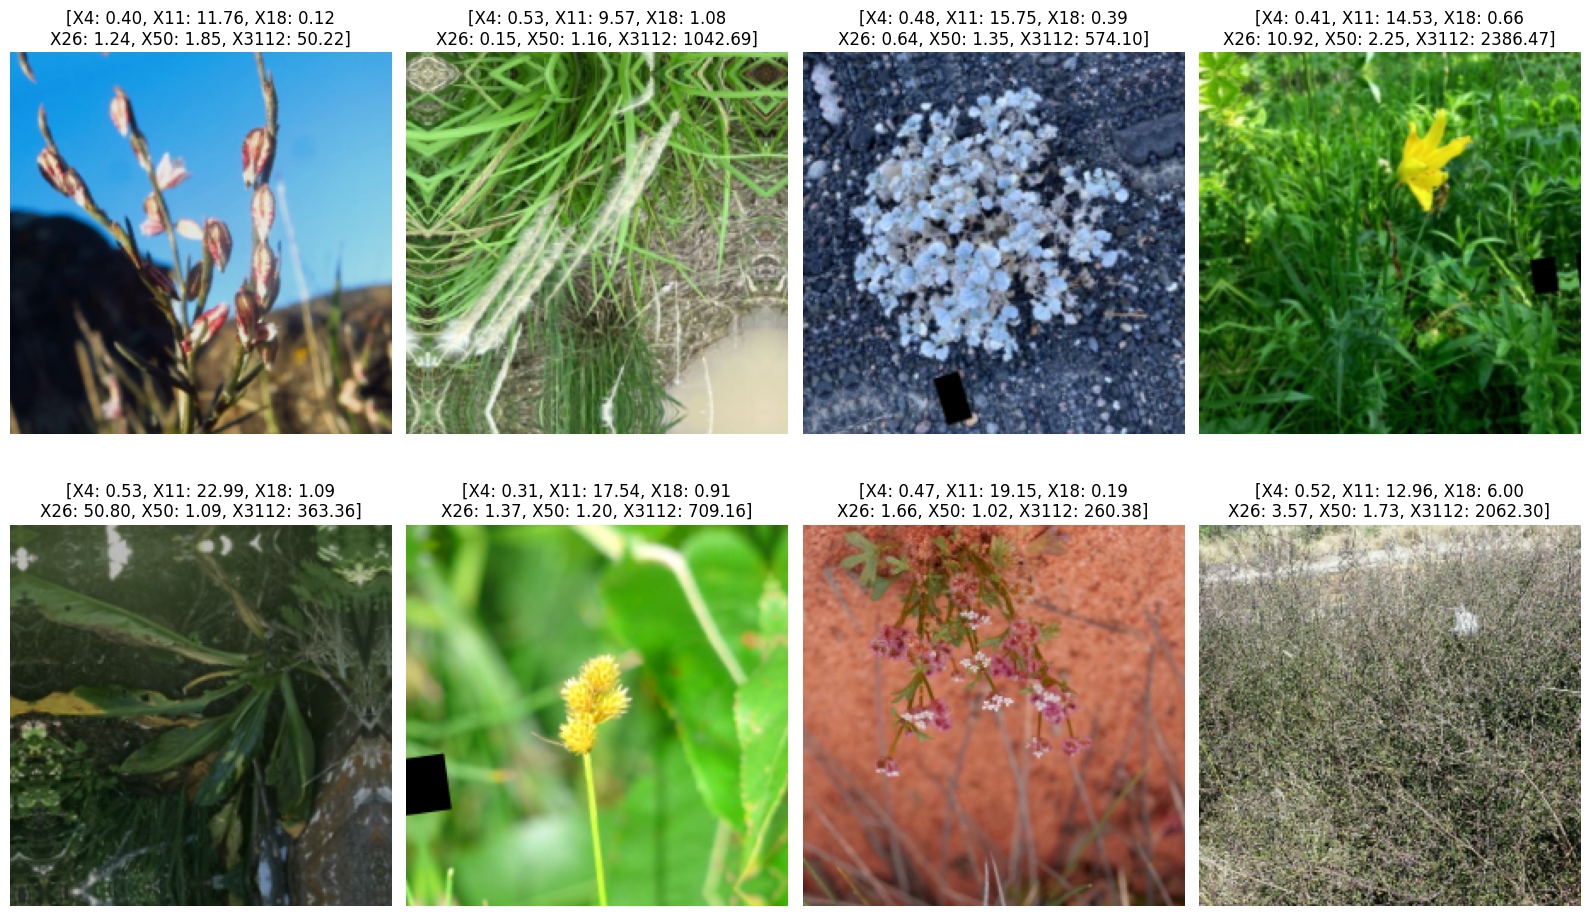

In [ ]:
inps, tars = next(iter(train_ds))
imgs = inps["images"]
num_imgs, num_cols = 8, 4

plt.figure(figsize=(4 * num_cols, num_imgs // num_cols * 5))
for i, (img, tar) in enumerate(zip(imgs[:num_imgs], tars[0][:num_imgs])):
    plt.subplot(num_imgs // num_cols, num_cols, i + 1)
    img = img. numpy()
    tar = tar.numpy()

    img = (img - img.min()) / (img.max() + 1e-4)

    formatted_tar = "\n".join(
        [
            ", ".join(
                f"{name.replace('_mean','')}: {val:.2f}"
                for name, val in zip(CFG.class_names[j : j + 3], tar[j : j + 3])
            )
            for j in range(0, len(CFG.class_names), 3)
        ]
    )

    plt.imshow(img)
    plt.title(f"[{formatted_tar}]")
    plt.axis("off")

plt.tight_layout()
plt.show()

### 🔍 | Loss & Metric

As mentioned on the board, I ultimately chose to use $R^2$

In [ ]:
from keras import ops

class R2Loss(keras.losses.Loss):
    def __init__(self, use_mask=False, name="r2_loss"):
        super().__init__(name=name)
        self.use_mask = use_mask

    def call(self, y_true, y_pred):
        if self.use_mask:
            mask = (y_true != -1)
            y_true = ops.where(mask, y_true, 0.0)
            y_pred = ops.where(mask, y_pred, 0.0)
        SS_res = ops.sum(ops.square(y_true - y_pred), axis=0)  # (B, C) -> (C,)
        SS_tot = ops.sum(ops.square(y_true - ops.mean(y_true, axis=0)), axis=0)  # (B, C) -> (C,)
        r2_loss = SS_res / (SS_tot + 1e-6)  # (C,)
        return ops.mean(r2_loss)  # ()

class R2Metric(keras.metrics.Metric):
    def __init__(self, name="r2", **kwargs):
        super(R2Metric, self).__init__(name=name, **kwargs)
        self.SS_res = self.add_weight(name='SS_res', shape=(6,), initializer='zeros')
        self.SS_tot = self.add_weight(name='SS_tot', shape=(6,) ,initializer='zeros')
        self.num_samples = self.add_weight(name='num_samples', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        SS_res = ops.sum(ops.square(y_true - y_pred), axis=0)
        SS_tot = ops.sum(ops.square(y_true - ops.mean(y_true, axis=0)), axis=0)
        self.SS_res.assign_add(SS_res)
        self.SS_tot.assign_add(SS_tot)
        self.num_samples.assign_add(ops.cast(ops.shape(y_true)[0], "float32"))

    def result(self):
        r2 = 1 - self.SS_res / (self.SS_tot + 1e-6)
        return ops.mean(r2)

    def reset_states(self):
        self.total_SS_res.assign(0)
        self.total_SS_tot.assign(0)
        self.num_samples.assign(0)

# 🤖 | Modeling

In this notebook, I utilized the `EfficientNetV2 B2` backbone from KerasCV's pretrained models to extract features from images and `Dense` layers to extract features from tabular data.
## Model Architecture Overview

- Image input → Main Task → Head
- Tabular input → Auxiliary Task → Aux Head



In [ ]:
# Define input layers
img_input = keras.Input(shape=(*CFG.image_size, 3), name="images")
feat_input = keras.Input(shape=(len(FEATURE_COLS),), name="features")

# Branch for image input
backbone = keras_cv.models.EfficientNetV2Backbone.from_preset(CFG.preset)
x1 = backbone(img_input)
x1 = keras.layers.GlobalAveragePooling2D()(x1)
x1 = keras.layers.Dropout(0.2)(x1)

# Branch for tabular/feature input
x2 = keras.layers.Dense(326, activation="selu")(feat_input)
x2 = keras.layers.Dense(64, activation="selu")(x2)
x2 = keras.layers.Dropout(0.1)(x2)

# Concatenate both branches
concat = keras.layers.Concatenate()([x1, x2])

# Output layer
out1 = keras.layers.Dense(CFG.num_classes, activation=None, name="head")(concat)
out2 = keras.layers.Dense(CFG.aux_num_classes, activation="relu", name="aux_head")(concat)
out = {"head": out1, "aux_head":out2}

# Build model
model = keras.models.Model([img_input, feat_input], out)

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss={
        "head": R2Loss(use_mask=False),
        "aux_head": R2Loss(use_mask=True), # use_mask to ignore `NaN` auxiliary labels
    },
    loss_weights={"head": 1.0, "aux_head": 0.3},  # more weight to main task
    metrics={"head": R2Metric()}, # evaluation metric only on main task
)

# Model Summary
model.summary()

Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ images (InputLayer) │ (None, 224, 224,  │       0 │ -                    │
│                     │ 3)                │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ features            │ (None, 163)       │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ efficient_net_v2b2… │ (None, 7, 7,      │ 8,769,… │ images[0][0]         │
│ (EfficientNetV2Bac… │ 1408)             │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense (Dense)       │ (None, 326)       │  53,464 │ features[0][0]       │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ global_average_poo… │ (None, 1408)      │       0 │ efficient_net_v2b2_… │
│ (GlobalAveragePool… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │  20,928 │ dense[0][0]          │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout (Dropout)   │ (None, 1408)      │       0 │ global_average_pool… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │       0 │ dense_1[0][0]        │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ concatenate         │ (None, 1472)      │       0 │ dropout[0][0],       │
│ (Concatenate)       │                   │         │ dropout_1[0][0]      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ aux_head (Dense)    │ (None, 6)         │   8,838 │ concatenate[0][0]    │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ head (Dense)        │ (None, 6)         │   8,838 │ concatenate[0][0]    │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 8,861,442 (33.80 MB)

 Trainable params: 8,779,154 (33.49 MB)

 Non-trainable params: 82,288 (321.44 KB)

### Plot Model

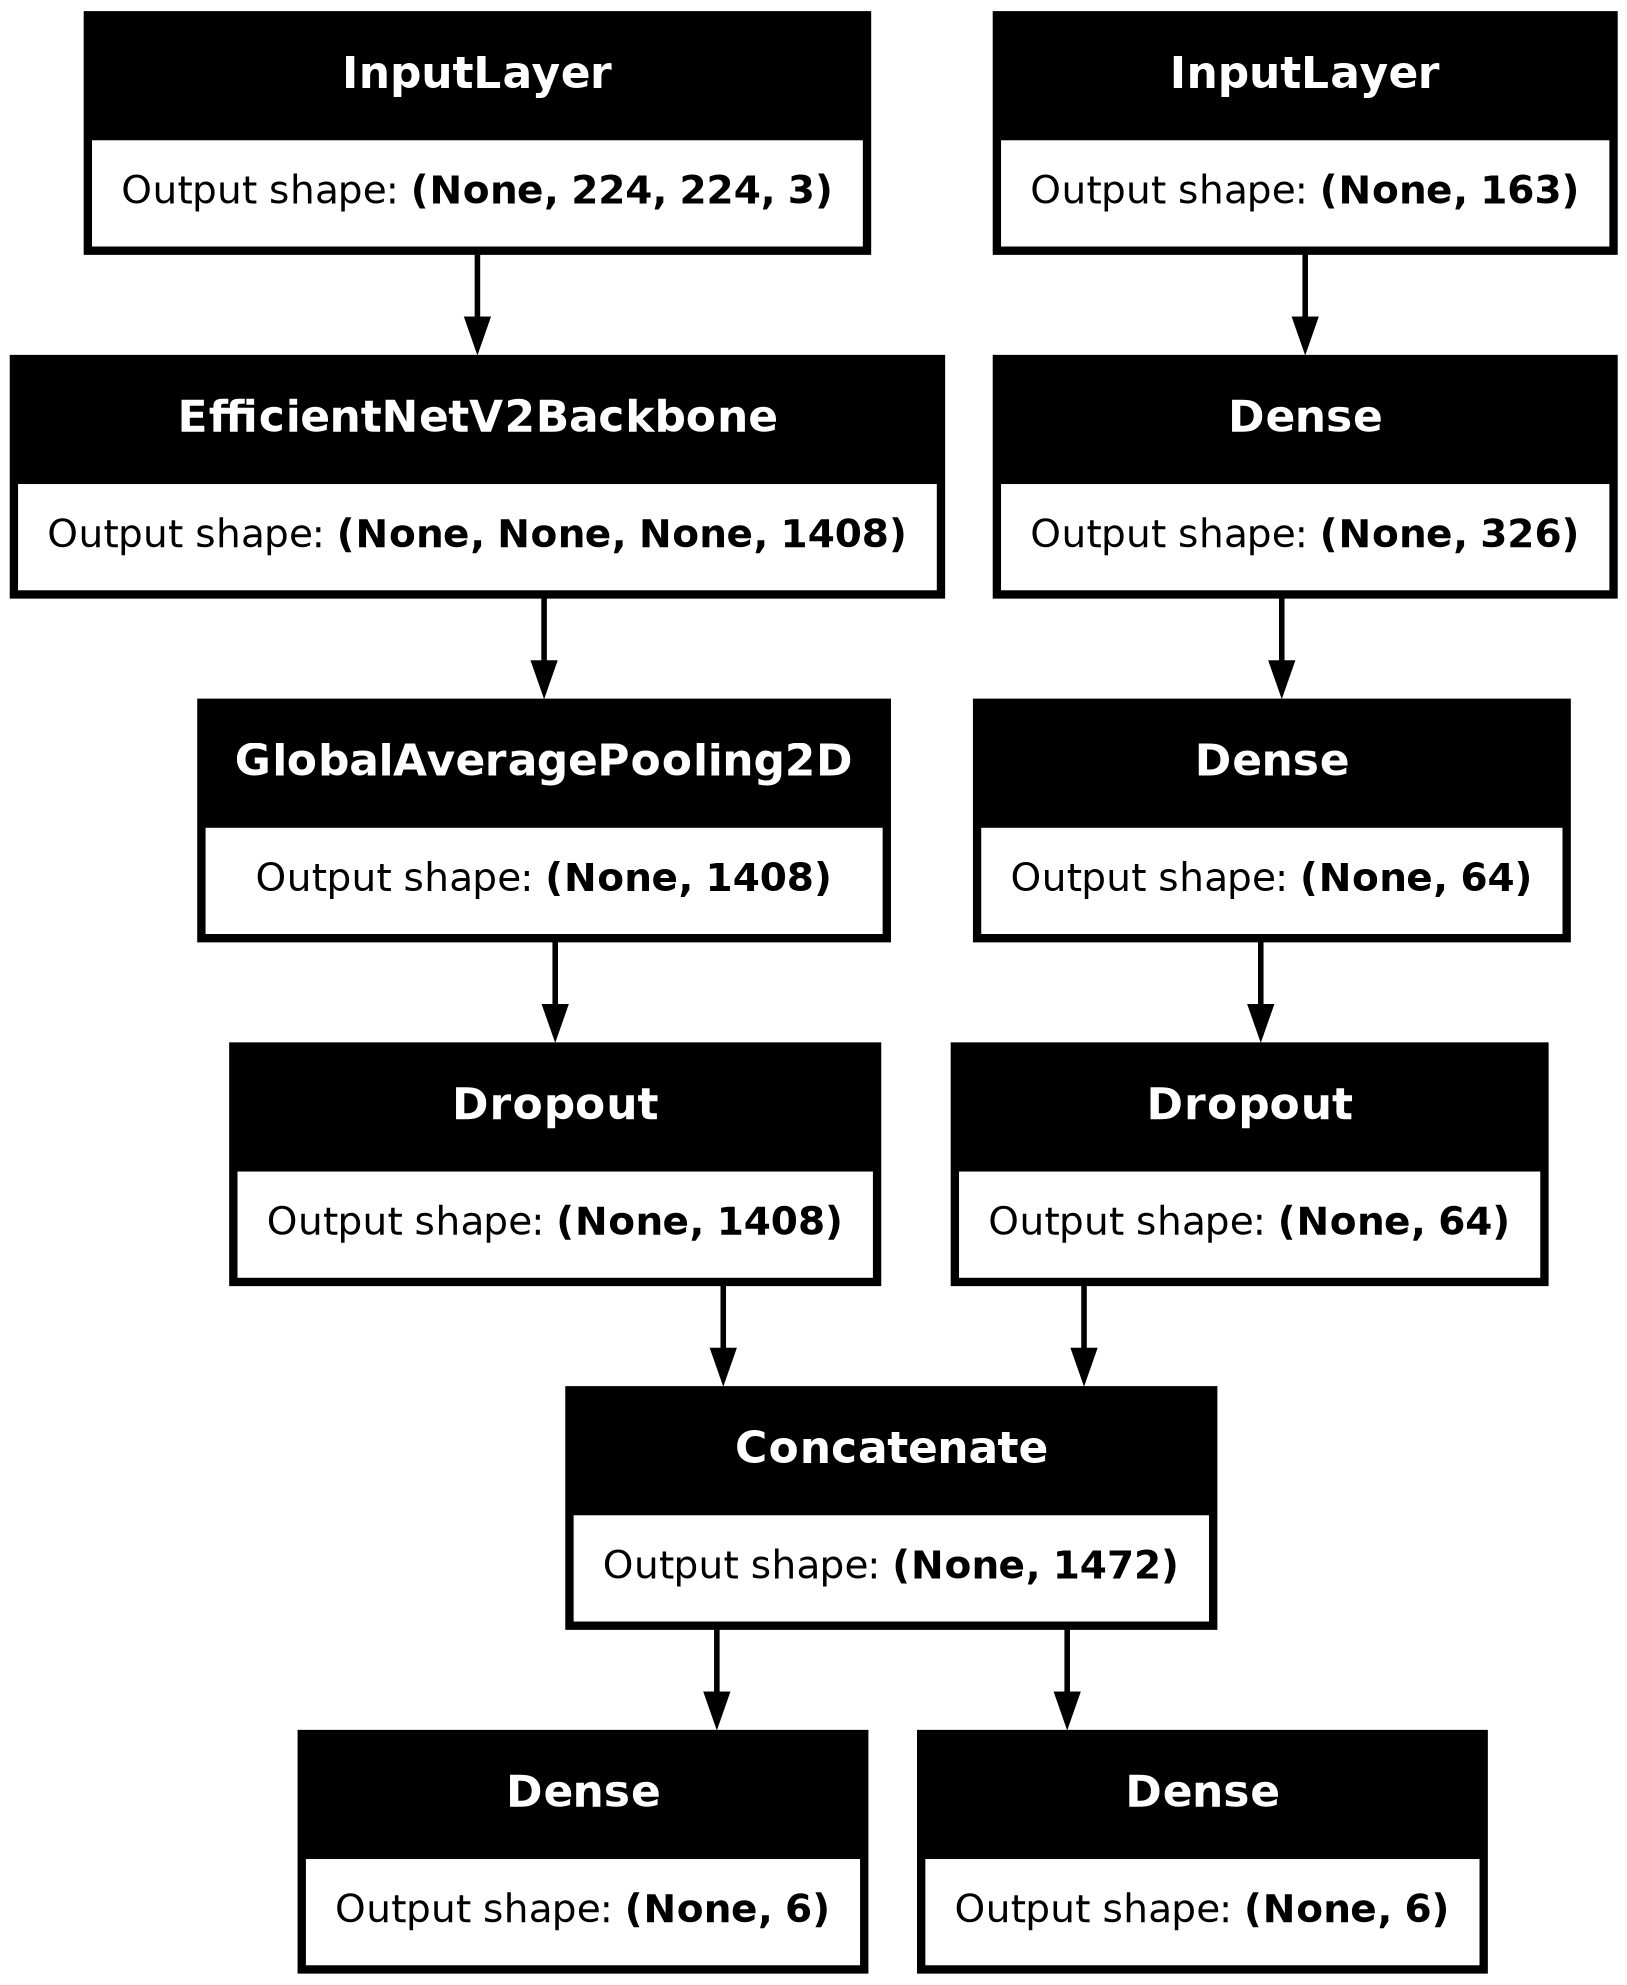

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

### ⚓ | LR Schedule

A well-structured learning rate schedule is essential for efficient model training, ensuring optimal convergence and avoiding issues such as overshooting or stagnation.

In [ ]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 5e-5, 8e-6 * batch_size, 1e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

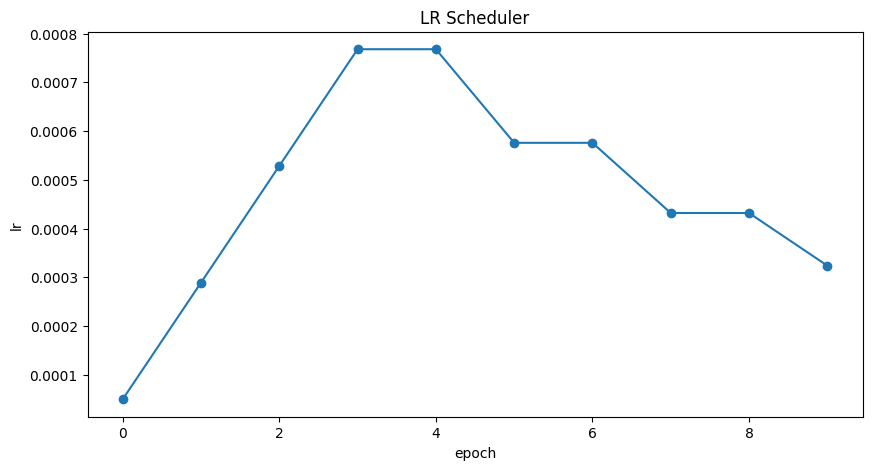

In [ ]:
lr_cb = get_lr_callback(CFG.batch_size, mode=CFG.lr_mode, plot=True)

### 💾 | Model Checkpoint

In [ ]:
ckpt_cb = keras.callbacks.ModelCheckpoint(
    "best_model.keras",
    monitor="val_head_r2",
    save_best_only=True,
    save_weights_only=False,
    mode="max",
)

### 🚂 | Training

In [ ]:
history = model.fit(
    train_ds,
    epochs=config.epochs,
    callbacks=[lr_cb, ckpt_cb],
    steps_per_epoch=len(train_df) // config.batch_size,
    validation_data=valid_ds,
    verbose=config.verbose,
)

### 📋 | Result

In [ ]:
# Best Result
best_R2 = max(history.history['val_head_r2'])
best_Epoch = np.argmax(history.history['val_head_r2']) + 1
print("#" * 10 + " Result " + "#" * 10)
print(f"Best R2: {best_R2:.5f}")
print(f"Best Epoch: {best_Epoch}")
print("#" * 28)

### 🧪 | Prediction

### Load Best Model

In [ ]:
model.load_weights("best_model.keras")

### Build Test Dataset

Don't forget to normalize for the test data as well.

In [ ]:
# Test
test_paths = test_df.image_path.values
test_features = scaler.transform(test_df[FEATURE_COLS].values)
test_ds = build_dataset(test_paths, test_features, batch_size=CFG.batch_size,
                         repeat=False, shuffle=False, augment=False, cache=False)

## Inference

As our model outputs predictions for two tasks and ultimately, I'm only interested in one (the mean), I will only use predictions from the main task (`head`) and ignore predictions from the auxiliary task.

In [ ]:
preds = model.predict(test_ds)["head"]

In [ ]:
!pip install notebook-as-pdf